# IMports

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from keras import layers
from sklearn.metrics import confusion_matrix, classification_report

# Load Data

In [3]:
df = pd.read_csv("/content/IMDB Dataset.csv")
df = df.sample(n=5000).reset_index(drop=True)
df.head()

,review,sentiment
0,"In Lizzie Borden's ""Love Crimes"" (1992), Sean ...",positive
1,"Humm, an Italian movie starred by David hassel...",negative
2,"""Hollywood Hotel"" is a fast-moving, exuberant,...",positive
3,"Writer & director Jay Andrews, a.k.a. Jim Wyno...",negative
4,I've seen all 3 now. I just can't believe how ...,negative


# Preprocess text

In [4]:
import re
import html
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# Download NLTK resources (only the first time)
nltk.download('stopwords')

# Initialize the stemmer and stopwords list
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

def clean_review_with_stopwords_and_stemming(review):
    # Decode HTML entities (like <br /> to actual line breaks)
    review = html.unescape(review)

    # Remove HTML tags (e.g., <br />)
    review = re.sub(r'<.*?>', '', review)

    # Convert to lowercase
    review = review.lower()

    # Remove non-alphabetic characters and digits
    review = re.sub(r'[^a-z\s]', '', review)

    # Tokenization: Split the review into words
    words = review.split()

    # Remove stopwords and apply stemming
    cleaned_words = [stemmer.stem(word) for word in words if word not in stop_words]

    # Rejoin the words back into a cleaned string
    cleaned_review = ' '.join(cleaned_words)

    return cleaned_review


# Assuming df is your DataFrame with reviews
df['review'] = df['review'].apply(clean_review_with_stopwords_and_stemming)

df


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,review,sentiment
0,lizzi borden love crime sean young play gritti...,positive
1,humm italian movi star david hasselhoff linda ...,negative
2,hollywood hotel fastmov exuber wonder entertai...,positive
3,writer director jay andrew aka jim wynorski se...,negative
4,ive seen cant believ bad naqoyqatsi comparison...,negative
...,...,...
4995,quit impress movi child eight nine gangster se...,negative
4996,movi perfect aspir screen writer actor directo...,negative
4997,jack frost return armi styrofoam ball foil sho...,negative
4998,straight point groov tube one unfunni unclev d...,negative


# Encoding

In [5]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
df['sentiment'] = encoder.fit_transform(df['sentiment'])
df.head()

,review,sentiment
0,lizzi borden love crime sean young play gritti...,1
1,humm italian movi star david hasselhoff linda ...,0
2,hollywood hotel fastmov exuber wonder entertai...,1
3,writer director jay andrew aka jim wynorski se...,0
4,ive seen cant believ bad naqoyqatsi comparison...,0


# Train Test Split

In [7]:
RANDOM_STATE = 42
text_train, text_test, y_train, y_test = train_test_split(df['review'], df['sentiment'], test_size=0.1, random_state=RANDOM_STATE)

# Tokenization

In [12]:
# Tokenize and transform to integer index
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text_train)

X_train = tokenizer.texts_to_sequences(text_train)
X_test = tokenizer.texts_to_sequences(text_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index
maxlen = max(len(x) for x in X_train) # longest text in train set

# Add padding to ensure all vectors have the same dimensionality
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)


X_train

array([[ 107,   20,   34, ...,    0,    0,    0],
       [1468,   14,  102, ...,    0,    0,    0],
       [4712,  118,    1, ...,    0,    0,    0],
       ...,
       [2036, 1185,   18, ...,    0,    0,    0],
       [ 477,   27,    1, ...,    0,    0,    0],
       [5712, 4997,  109, ...,    0,    0,    0]], dtype=int32)

# CNN Architecture

In [13]:
# Define CNN model
embedding_dim = 100

model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())


model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))  # Output layer for binary classification
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [14]:
history = model.fit(X_train, y_train, epochs=5,batch_size=64,verbose=True, validation_data=(X_test, y_test))

Epoch 1/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - accuracy: 0.5424 - loss: 0.6876 - val_accuracy: 0.7320 - val_loss: 0.5994
Epoch 2/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7878 - loss: 0.5088 - val_accuracy: 0.8520 - val_loss: 0.3743
Epoch 3/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9387 - loss: 0.2138 - val_accuracy: 0.8460 - val_loss: 0.3680
Epoch 4/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9941 - loss: 0.0586 - val_accuracy: 0.8500 - val_loss: 0.3900
Epoch 5/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9997 - loss: 0.0108 - val_accuracy: 0.8460 - val_loss: 0.4239


# Visualize accuracy

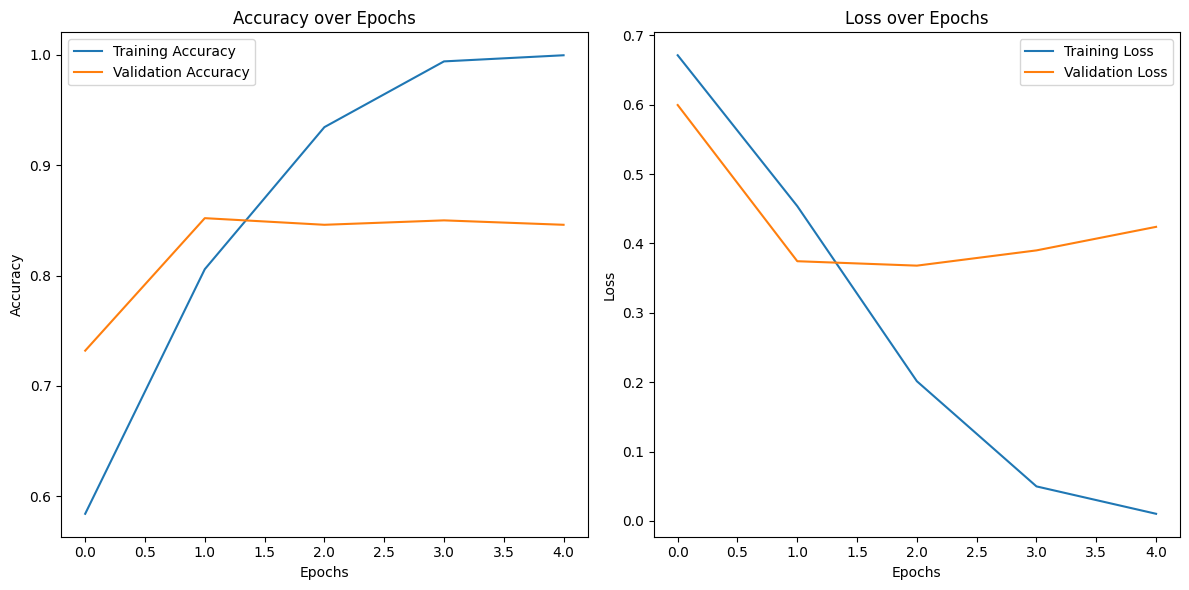

In [15]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()

# Confusion and Classification Report

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.83      0.84       247
           1       0.84      0.86      0.85       253

    accuracy                           0.85       500
   macro avg       0.85      0.85      0.85       500
weighted avg       0.85      0.85      0.85       500



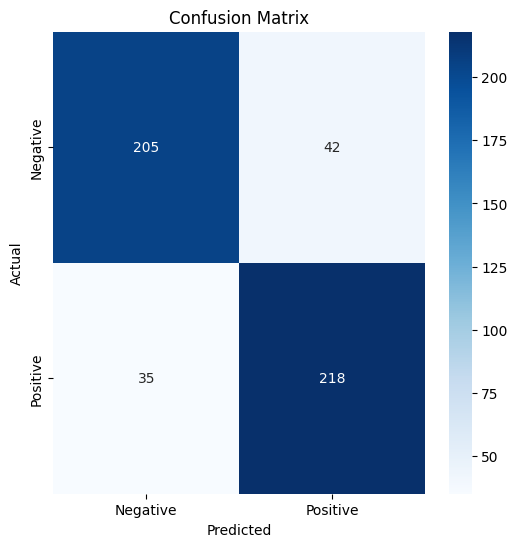

In [18]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predict on the test data
y_pred = (model.predict(X_test) > 0.5).astype(int)

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Predict script

In [22]:
def predict_sentiment(review,tokenizer, model,maxlen):
  text = clean_review_with_stopwords_and_stemming(review)

  sequence = tokenizer.texts_to_sequences([text])
  padded_sequence = pad_sequences(sequence, padding='post', maxlen=maxlen)

  prediction = model.predict(padded_sequence)[0][0]

  if prediction > 0.5:
    return "Positive"
  else:
    return "Negative"

In [23]:
input_text = "This movie is amazing!"
predict_sentiment(input_text,tokenizer,model,maxlen)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step


'Positive'

In [24]:
input_text = "it was bad movie"
predict_sentiment(input_text,tokenizer,model,maxlen)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


'Negative'

# Save Model, Tokenizer

In [26]:
model.save("cnn_sent_model.h5")

import pickle
pickle.dump(tokenizer,open("tokenizer.pkl","wb"))